### Introduction to Monte Carlo Simulation in Finance
# Multiasset Simulation

## Cholesky Decomposition

The **Choleski Decomposition** makes an appearance in Monte Carlo Methods where it is used to simulating systems with correlated variables.  Cholesky decomposition is applied to the correlation matrix, providing a lower triangular matrix $A$, which when applied to a vector of uncorrelated samples, $u$, produces the covariance vector of the system. Thus it is highly relevant for quantitative trading.

The standard procedure for generating a set of correlated normal random variables is through a linear combination of uncorrelated normal random variables;
Assume we have a set of $n$ independent standard normal random variables $Z$ and we want to build a set of $n$ correlated standard normals $Z^\prime$ with correlation matrix $\Sigma$
$$
Z^\prime = AZ, \quad \quad AA^t = \Sigma
$$

We can find a solution for $A$ in the form of a triangular matrix
$$
\begin{pmatrix} 
A_{11} & 0 & \dots & 0  \\ 
A_{21} & A_{22} & \dots & 0  \\ 
\vdots & \vdots & \ddots & \dots  \\ 
A_{n1} & A_{n2} & \dots & A_{nn}   
\end{pmatrix}
$$

**diagonal elements**
$$
a_{ii} = \sqrt{\Sigma_{ii} - \sum\limits_{k=1}^{i-1} a_{ik}^2}
$$

**off-diagonal elements**
$$
a_{ij} = \frac{1}{a_{ii}} \left( \Sigma_{ij} - \sum\limits_{k=1}^{i-1} a_{ik} a_{jk} \right)
$$

Using Python, the most efficient method in both development and execution time is to make use of the NumPy/SciPy linear algebra (linalg) library, which has a built in method cholesky to decompose a matrix. The optional lower parameter allows us to determine whether a lower or upper triangular matrix is produced: 

In [1]:
import pprint
import scipy
import scipy.linalg   # SciPy Linear Algebra Library

A = scipy.array([[6, 3, 4, 8], [3, 6, 5, 1], [4, 5, 10, 7], [8, 1, 7, 25]])
L = scipy.linalg.cholesky(A, lower=True)
U = scipy.linalg.cholesky(A, lower=False)

print "A:"
pprint.pprint(A)

print "L:"
pprint.pprint(L)

print "U:"
pprint.pprint(U)

A:
array([[ 6,  3,  4,  8],
       [ 3,  6,  5,  1],
       [ 4,  5, 10,  7],
       [ 8,  1,  7, 25]])
L:
array([[ 2.44948974,  0.        ,  0.        ,  0.        ],
       [ 1.22474487,  2.12132034,  0.        ,  0.        ],
       [ 1.63299316,  1.41421356,  2.30940108,  0.        ],
       [ 3.26598632, -1.41421356,  1.58771324,  3.13249102]])
U:
array([[ 2.44948974,  1.22474487,  1.63299316,  3.26598632],
       [ 0.        ,  2.12132034,  1.41421356, -1.41421356],
       [ 0.        ,  0.        ,  2.30940108,  1.58771324],
       [ 0.        ,  0.        ,  0.        ,  3.13249102]])


For example, for a two-dimension random vector we have simply
$$
A=
\begin{pmatrix} 
\sigma_1        & 0   \\ 
\sigma_2 \rho & \sigma_2 \sqrt{1-\rho^2}   
\end{pmatrix}
$$

Say one needs to generate two correlated normal variables $x_1$ and $x_2$. All one needs to do is to generate two uncorrelated Gaussian random variables $z_1$ and$ z_2$ and set
$$
x_1 = z_1 
$$

$$
x_2 =  \rho z_1 + \sqrt{1-\rho^2} z_2
$$

In Python everything you need is available in the *numpy* library, as we can see in the next example.

C:\Users\User\Anaconda2\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


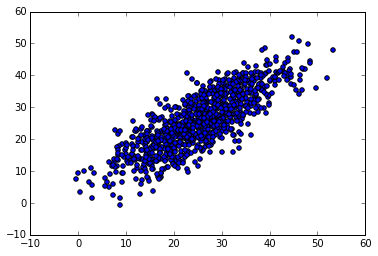

In [2]:
%matplotlib inline

import numpy as np
import scipy as sc

from math        import sqrt
from scipy.stats import norm as scnorm
from pylab       import *
from matplotlib  import pyplot as pl

xx = np.array([-0.51, 51.2])
yy = np.array([0.33, 51.6])
means = [xx.mean(), yy.mean()]  
stds = [xx.std() / 3, yy.std() / 3]
corr = 0.8         # correlation
covs = [[stds[0]**2          , stds[0]*stds[1]*corr], 
        [stds[0]*stds[1]*corr,           stds[1]**2]] 

m = np.random.multivariate_normal(means, covs, 1000).T
scatter(m[0], m[1])

## Brownian simulation of correlated assets

When using Monte Carlo methods to price options dependent on a basket of underlying assets (multidimensional stochastic simulations), the correlations between assets should be considered. Here I will show an example of how this can be simulated using pandas. 

Download and prepare the data

First we download some data from Yahoo:

In [3]:
from pandas.io.data import DataReader
from pandas import Panel, DataFrame

symbols = ['AAPL',    # Apple Inc.
           'GLD',     # SPDR Gold Trust ETF
           'SNP',     # S&P 500 Index
           'MCD']     # McDonald's Corporation
data = dict((symbol, DataReader(symbol, "yahoo", pause=1)) for symbol in symbols)
panel = Panel(data).swapaxes('items', 'minor')
closing = panel['Close'].dropna()
closing.head()

C:\Users\User\Anaconda2\lib\site-packages\pandas\io\data.py:33: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


,AAPL,GLD,MCD,SNP
Date,,,,
2010-01-04,214.009998,109.800003,62.779999,87.899990
2010-01-05,214.379993,109.699997,62.299999,86.969999
2010-01-06,210.969995,111.510002,61.450001,88.199996
2010-01-07,210.580000,110.820000,61.900002,86.820006
2010-01-08,211.980005,111.370003,61.840000,87.129999


Now we can calculate the log returns:

In [4]:
rets = log(closing / closing.shift(1)).dropna()
rets.head()

,AAPL,GLD,MCD,SNP
Date,,,,
2010-01-05,0.001727,-0.000911,-0.007675,-0.010636
2010-01-06,-0.016034,0.016365,-0.013738,0.014044
2010-01-07,-0.001850,-0.006207,0.007296,-0.015770
2010-01-08,0.006626,0.004951,-0.000970,0.003564
2010-01-11,-0.008861,0.013201,0.007732,0.000803


The correlation matrix has information about the historical correlations between stocks in the group. We work under the assumption that this quantity is conserved, so the generated stocks will need to satisfy this condition:

In [5]:
corr_matrix = rets.corr()
corr_matrix

,AAPL,GLD,MCD,SNP
AAPL,1.000000,0.016617,0.126259,0.084351
GLD,0.016617,1.000000,-0.024091,0.063853
MCD,0.126259,-0.024091,1.000000,0.285418
SNP,0.084351,0.063853,0.285418,1.000000


So the most correlated assets are MCD (McDonald's Corporation) and the SPX (S&P 500 Index). Pandas has a nice utility to plot the correlations:

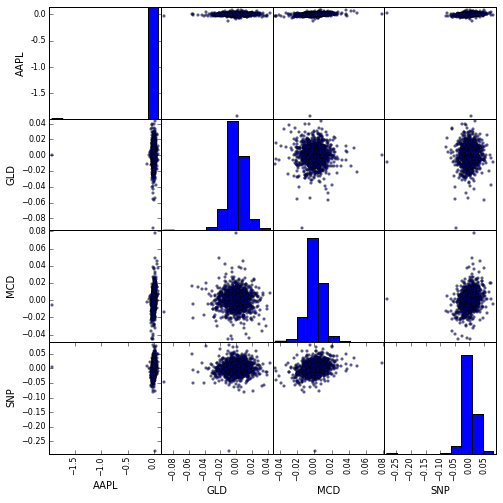

In [6]:
from pandas.tools.plotting import scatter_matrix

scatter_matrix(rets, figsize=(8,8));

### Simulation

The simulation procedure for generating random variables will go like this:

1. Calculate the Cholesky Decomposition matrix, this step will return an upper triangular matrix  $L^T$.
2. Generate random vector  $X \sim N(0,1)$.
3. Obtain a correlated random vector  $Z=XL^T$.

As we have previously seen the Cholesky decomposition of the correlation matrix corr_matrix is impemented in scipy:

In [7]:
from scipy.linalg import cholesky

upper_cholesky = cholesky(corr_matrix, lower=False)
upper_cholesky

array([[ 1.        ,  0.01661716,  0.12625905,  0.0843506 ],
       [ 0.        ,  0.99986193, -0.02619233,  0.06246024],
       [ 0.        ,  0.        ,  0.99165146,  0.27873099],
       [ 0.        ,  0.        ,  0.        ,  0.95461654]])

We set up the parameters for the simulation:

In [8]:
import numpy as np 
from pandas import bdate_range   # business days

n_days = 21
dates = bdate_range(start=closing.ix[-1].name, periods=n_days)
n_assets = len(symbols)
n_sims = 1000
dt = 1./252
mu = rets.mean().values
sigma = rets.std().values*sqrt(252)
np.random.seed(1234)            # init random number generator for reproducibility

Now we generate the correlated random values $X$:

In [63]:
rand_values = np.random.standard_normal(size = (n_days * n_sims, n_assets)) #
corr_values = rand_values.dot(upper_cholesky)*sigma
corr_values

array([[ 0.38308566, -0.2070233 ,  0.23083281,  0.02016337],
       [-0.5855465 ,  0.15313317,  0.11296307, -0.1163267 ],
       [ 0.01275479, -0.39238639,  0.18326384,  0.35079875],
       ..., 
       [-0.58853506, -0.32353706, -0.17135312, -0.93662803],
       [ 0.35453037, -0.20091232, -0.10716873, -0.29080728],
       [ 0.51699672,  0.14838484, -0.11943093,  0.11472642]])

With everything set up we can start iterating through the time interval. The results for each specific time are saved along the third axis of a pandas Panel.

In [64]:
prices = Panel(items=range(n_sims), minor_axis=symbols, major_axis=dates)
prices.ix[:, 0, :] = closing.ix[-1].values.repeat(1000).reshape(4,1000).T # set initial values

for i in range(1,n_days):
    prices.ix[:, i, :] = prices.ix[:, i-1,:] * (exp((mu-0.5*sigma**2)*dt +  sqrt(dt)*corr_values[i::n_days])).T    

prices.ix[123, :, :].head()   # show random path

,AAPL,GLD,SNP,MCD
2016-05-09,92.790001,120.650002,130.830002,65.949997
2016-05-10,99.224229,121.180540,131.820202,66.290071
2016-05-11,92.158884,120.130085,132.338982,65.785188
2016-05-12,97.664065,121.233817,131.757252,66.091981
2016-05-13,101.718582,121.303794,131.622994,64.136477


And thats all! Now it is time to check our results. First a plot of all random paths for AAPL (Apple Inc.).

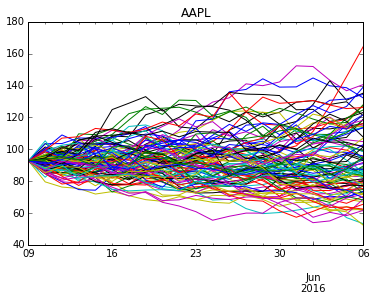

In [65]:
prices.ix[::10, :, 'AAPL'].plot(title='AAPL', legend=False);

We can take a look at the statistics for the last day:

In [66]:
prices.ix[:, -1, :].T.describe()

,AAPL,GLD,SNP,MCD
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,92.465761,120.606154,130.843878,65.926332
std,21.896580,6.017579,5.706805,5.584356
min,44.880606,104.920176,110.869273,47.416883
25%,76.597974,116.324221,126.879764,61.972659
50%,89.460169,120.449837,130.875054,65.812684
75%,105.913077,124.616598,134.369685,69.479817
max,166.610257,139.549397,151.992319,83.879169


## Simulating correlated random walks with Copulas

In [9]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from copulalib.copulalib import Copula
plt.style.use('ggplot')


def generateData():
    global x,y
    x = np.random.normal(size=250)
    y = 2.5*x + np.random.normal(size=250)

# Data and histograms
def plotData():
    global x,y
    fig = plt.figure()
    fig.add_subplot(2,2,1)
    plt.hist(x,bins=20,color='green',alpha=0.8,align='mid')
    plt.title('X variable distribution')
    fig.add_subplot(2,2,3)
    plt.scatter(x,y,marker="o",alpha=0.8)
    fig.add_subplot(2,2,4)
    plt.title('Joint X,Y')
    plt.hist(y,bins=20,orientation='horizontal',color='red',alpha=0.8,align='mid')
    plt.title('Y variable distribution')    
    plt.show()

def generateCopulas():
    global x,y
    fig = plt.figure()

    frank = Copula(x,y,family='frank')
    uf,vf = frank.generate_uv(1000)
    fig.add_subplot(2,2,1)
    plt.scatter(uf,vf,marker='.',color='blue')
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.title('Frank copula')

    clayton = Copula(x,y,family='clayton')
    uc,vc = clayton.generate_uv(1000)
    fig.add_subplot(2,2,2)
    plt.scatter(uc,vc,marker='.',color='red')
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.title('Clayton copula')

    gumbel = Copula(x,y,family='gumbel')
    ug,vg = gumbel.generate_uv(1000)
    fig.add_subplot(2,2,3)
    plt.scatter(ug,vg,marker='.',color='green')
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.title('Gumbel copula')

    plt.show()

#-------------------------------------------------------------------------------
# Run the functions

generateData()
plotData()
generateCopulas()

ImportError: DLL load failed: %1 non è un'applicazione di Win32 valida.